In [125]:
# Import necessary packages
import pandas as pd
import numpy as np
import datetime
from tabulate import tabulate
from tableone import TableOne
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import math
import os

In [126]:
#Find the file you want to load in
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

#input path here 
path = 'C:\\Users\\gabel\\Downloads'
# path = '../Capstone_Data
file_path = find('target_drugs_sample.csv', path)
# Load in file
df = pd.read_csv(file_path)

#faers_dictionary = pd.read_excel(find('faers_analysis_dataset_dictionary.xlsx', path))

df_dictionary = pd.read_excel(find('faers_analysis_dataset_dictionary.xlsx', path), sheet_name=None)
for sheet_name, drug in df_dictionary.items():
    # Perform your processing here
    print(f"Sheet name: {sheet_name}")

#Get the sheet named Psychiatric Disorder Reac Grp from df_dictionary
df_faers_data_dictionary = df_dictionary['faers_2004_2024q1_dictionary']
df_target_drugs = df_dictionary['Target Drugs']
df_psychiatric = df_dictionary['Psychiatric Disorder Reac Grp']

Sheet name: faers_2004_2024q1_dictionary
Sheet name: Target Drugs
Sheet name: Psychiatric Disorder Reac Grp


In [127]:
df_target_drugs['Brand Name'] = df_target_drugs['Brand Name'].str.replace('Singulaira', 'Singulair')
#Get the rows of the drugs I need, dont need nans
df_target_drugs = df_target_drugs.iloc[:7]
df_target_drugs

,Generic Name,Brand Name,Initial Approval Date,Note
0,Montelukast,Singulair,1998-02-20,Label
1,Zafirlukast,Accolate,1996-09-26,Label
2,Zileuton,Zyflo,1996-12-09,Label
3,Levocetirizine,Xyzal,2007-05-25,Label
4,Cetirizine,Zyrtec,1996-09-27,Label
5,Fexofenadine,Allegra,1996-07-25,Label
6,Loratadine,Claritin,1993-04-12,Label


In [128]:
df.tail(50)

,caseid,ps_drugname,ps_indi_pt,ss_drugname,ss_indi_pt,c_i_drugname,c_i_indi_pt,reaction_pt,age,age_cod,sex,event_dt,init_fda_dt,fda_dt,rept_dt,occr_country,outc_cod,rpsr_cod
151468,20482555.0,ADALIMUMAB,Product used for unknown indication,ETANERCEPT;IBANDRONIC ACID;LETROZOLE;ATORVASTA...,Product used for unknown indication;NA,NaN,NaN,Photophobia;Vomiting;Fall;Cardio-respiratory a...,NaN,NaN,NaN,NaN,20220217.0,20240329,20240328.0,PT,DE;OT,NaN
151469,20508817.0,COSENTYX,Psoriatic arthropathy,ERELZI;ADALIMUMAB;DICLOFENAC;FOLIC ACID;METHOT...,Rheumatoid arthritis;NA;Product used for unkno...,PANTOPRAZOLE;DOXYCYCLINE;DESOXIMETASONE;CHOLEC...,Product used for unknown indication;NA;Rheumat...,Dizziness;Medication error;Joint stiffness;Gas...,43.0,YR,F,NaN,20220223.0,20240320,20240321.0,CA,HO;LT;DS;OT;CA;DE,NaN
151470,20525020.0,MONTELUKAST,Product used for unknown indication,ALENDRONIC ACID;CANDESARTAN;METFORMIN HYDROCHL...,Product used for unknown indication;Eosinophil...,SULFATRIM;SULFAMETHOXAZOLE\TRIMETHOPRIM;PENICI...,Product used for unknown indication;NA,Pulmonary embolism;Mite allergy;Sleep disorder...,65.0,YR,M,NaN,20220228.0,20240308,20240308.0,CA,HO;LT;OT,NaN
151471,20534438.0,SINGULAIR,Asthma,NaN,NaN,NaN,NaN,Depression;Disturbance in attention;Anxiety;Fa...,NaN,NaN,M,19980101.0,20220302.0,20240129,20240129.0,US,DS;HO;OT,NaN
151472,20539036.0,HYDROMORPHONE HYDROCHLORIDE,Product used for unknown indication,HYDROMORPHONE HYDROCHLORIDE;BUTRANS;BUPRENORPH...,NA;Product used for unknown indication;Migraine,NaN,NaN,Gastrooesophageal reflux disease;Drug ineffect...,43.0,YR,F,NaN,20220302.0,20240209,20240209.0,CA,OT,NaN
151473,20545804.0,SINGULAIR,Asthma,NaN,NaN,NaN,NaN,Ligament sprain;Migraine;Wheezing;Insomnia;Sui...,NaN,NaN,F,20000101.0,20220303.0,20240125,20240125.0,US,DS;OT;HO,NaN
151474,20572016.0,SINGULAIR,NaN,SINGULAIR;ADVAIR HFA,Asthma;NA,PREDNISONE;CLARITHROMYCIN;SYMBICORT;ALBUTEROL ...,NaN,Generalised anxiety disorder;Intentional self-...,NaN,NaN,F,20070101.0,20220309.0,20240215,20240215.0,US,HO;DS;OT,NaN
151475,20575288.0,SINGULAIR,Asthma,SYMBICORT;QVAR;ALBUTEROL SULFATE;VENTOLIN HFA;...,NA;Suicide attempt,VALIUM;NEXIUM I.V.;VENLAFAXINE,NA;Pain,Abdominal discomfort;Major depression;Back pai...,NaN,NaN,M,20180101.0,20220310.0,20240305,20240305.0,US,DS;HO;OT,NaN
151476,20587301.0,ESOMEPRAZOLE,Product used for unknown indication,ESOMEPRAZOLE;ESCITALOPRAM;EZETIMIBE;HYDROCHLOR...,Product used for unknown indication;NA;Blood p...,TRAMADOL HYDROCHLORIDE;VORTIOXETINE;BUPRENORPH...,Product used for unknown indication,Tinnitus;Dyspnoea;Blindness;Syncope;Head disco...,NaN,NaN,NaN,NaN,20220314.0,20240119,20240119.0,PT,DE;OT,NaN
151477,20604931.0,ALISKIREN,Product used for unknown indication,EZETIMIBE;HYDROCHLOROTHIAZIDE;DUTASTERIDE;ATOR...,Product used for unknown indication;NA;Blood p...,NaN,NaN,Off label use;Pruritus;Generalised oedema;Tinn...,NaN,NaN,NaN,NaN,20220317.0,20240328,20240328.0,PT,DE;OT,NaN


In [129]:
print("The number of unique names in the primary drug column is:", len(df['ps_drugname'].unique()))

The number of unique names in the primary drug column is: 4594


In [130]:
# Extract ps_drugname values and target drug names
ps_drugnames = df['ps_drugname'].dropna().unique().tolist()
target_drug_names = df_target_drugs['Generic Name'].tolist() + df_target_drugs['Brand Name'].tolist()

# Combine ps_drugnames and target drug names for vectorization
all_drug_names = ps_drugnames + target_drug_names

# Vectorize using TF-IDF
vectorizer = TfidfVectorizer()
drug_vectors = vectorizer.fit_transform(all_drug_names)

# Split vectors into ps_drugname and target_drugname vectors
ps_vectors = drug_vectors[:len(ps_drugnames)]
target_vectors = drug_vectors[len(ps_drugnames):]

# Compute cosine similarity between ps_drugnames and target drug names
similarities = cosine_similarity(ps_vectors, target_vectors)

threshold = 0.6
ps_drugname_to_brand = {}

for i, ps_name in enumerate(ps_drugnames):
    sim_scores = similarities[i]
    max_index = sim_scores.argmax()
    max_score = sim_scores[max_index]
    if max_score >= threshold:
        ps_drugname_to_brand[ps_name] = target_drug_names[max_index]

# Apply the replacement in the dataframe
df['ps_drugname'] = df['ps_drugname'].replace(ps_drugname_to_brand)

#Map the generic names to the brand names in df
df['ps_drugname'] = df['ps_drugname'].map(df_target_drugs.set_index('Generic Name')['Brand Name']).fillna(df['ps_drugname'])

# Display the updated dataframe to the user
df.tail(10)

,caseid,ps_drugname,ps_indi_pt,ss_drugname,ss_indi_pt,c_i_drugname,c_i_indi_pt,reaction_pt,age,age_cod,sex,event_dt,init_fda_dt,fda_dt,rept_dt,occr_country,outc_cod,rpsr_cod
151508,21947290.0,XYWAV,Narcolepsy,XYWAV;CLARITIN;ZYRTEC;IMBRUVICA;IVIZIA DRY EYE,Cataplexy;Somnolence;Product used for unknown ...,DOCUSATE SODIUM;OSTEO BI-FLEX EASE;MAGNESIUM O...,Product used for unknown indication,Shoulder operation;Abdominal discomfort;Produc...,79.0,YR,F,20231127.0,20230202.0,20240311,20240311.0,US,OT,NaN
151509,22046139.0,XYWAV,Narcolepsy,XYWAV;CETIRIZINE HYDROCHLORIDE;HALDOL;ATIVAN,Somnolence;NA;Product used for unknown indication,LAMICTAL;PROPRANOLOL;MODAFINIL,Product used for unknown indication;Essential ...,Vertigo;Nausea;Wrong technique in product usag...,17.0,YR,F,20230322.0,20230228.0,20240226,20240226.0,US,HO;OT,NaN
151510,22269426.0,CIMZIA,Rheumatoid arthritis,CIMZIA;CETIRIZINE HYDROCHLORIDE;CETIRIZINE HYD...,Psoriatic arthropathy;Psoriasis;Rheumatoid art...,ATIVAN;DESOGESTREL\ETHINYL ESTRADIOL;DEXAMETHA...,Product used for unknown indication,Oedema;Psoriatic arthropathy;Lip dry;Hip arthr...,50.0,YR,F,NaN,20230501.0,20240119,20240119.0,CA,DE;DS;HO;LT;OT,NaN
151511,22279036.0,ENBREL,Psoriatic arthropathy,ENBREL;OTEZLA;RITUXIMAB;INFLIXIMAB;ACETAMINOPH...,Rheumatoid arthritis;NA;Product used for unkno...,Atasol;ATIVAN;CAFFEINE;CAFFEINE CITRATE;CODEIN...,NA;Product used for unknown indication,Prescribed overdose;Glossodynia;Drug hypersens...,50.0,YR,F,NaN,20230503.0,20240319,20240319.0,CA,LT;OT;DS;DE;HO,NaN
151512,22292648.0,METHOTREXATE SODIUM,Rheumatoid arthritis,ENBREL;LEUCOVORIN CALCIUM;CELEBREX;INFLIXIMAB;...,Rheumatoid arthritis;Psoriatic arthropathy;NA;...,ACETAMINOPHEN;ATIVAN;CAFFEINE;CAFFEINE CITRATE...,NaN,Oedema;Glossodynia;Blister;Hypoaesthesia;Anxie...,50.0,YR,F,NaN,20230508.0,20240322,20240322.0,CA,DE;DS;HO;LT;OT,NaN
151513,22322523.0,Singulair,Product used for unknown indication,SINGULAIR;PROMETRIUM;ABACAVIR SULFATE;ABACAVIR...,NA;Product used for unknown indication;Rheumat...,DOLUTEGRAVIR SODIUM,Product used for unknown indication,Drug ineffective;Upper respiratory tract infec...,36.0,YR,F,NaN,20230516.0,20240322,20240322.0,CA,DE;OT,NaN
151514,22370495.0,ETANERCEPT,Blood pressure measurement,ADALIMUMAB;NITROGLYCERIN;EXEMESTANE;DONEPEZIL ...,Product used for unknown indication;NA,NaN,NaN,Abdominal pain upper;Cardio-respiratory arrest...,NaN,NaN,NaN,NaN,20230526.0,20240322,20240322.0,PT,OT;DE,NaN
151515,22374538.0,RITUXIMAB,Rheumatoid arthritis,ENBREL;RITUXIMAB;ADALIMUMAB;CALCIUM CHLORIDE;H...,Rheumatoid arthritis;NA;Arthritis;Psoriatic ar...,PANTOPRAZOLE SODIUM ANHYDROUS;ATIVAN;CAFFEINE;...,NA;Anxiety,Abdominal pain upper;Maternal exposure during ...,NaN,NaN,F,NaN,20230526.0,20240326,20240326.0,CA,HO;DS;LT;OT,NaN
151516,22375054.0,INFLIXIMAB,Psoriatic arthropathy,INFLIXIMAB;ENBREL;LEUCOVORIN CALCIUM;CELEBREX;...,Rheumatoid arthritis;Psoriatic arthropathy;NA;...,ACETAMINOPHEN;ATIVAN;CAFFEINE;CAFFEINE CITRATE...,NaN,Irritable bowel syndrome;Paraesthesia;Muscle i...,NaN,NaN,NaN,NaN,20230527.0,20240327,20240327.0,CA,DS;DE;HO;OT;LT,NaN
151517,22791691.0,GILENYA,Multiple sclerosis,GILENYA;LORATADINE,NA;Product used for unknown indication,VITAMIN D NOS;SERTRALINE;VITAMIN C;CITALOPRAM;...,Supplementation therapy;Antidepressant therapy...,Myalgia;Urinary tract infection;Anxiety;Hemihy...,21.0,YR,F,20230801.0,20230807.0,20240220,20240220.0,MX,OT,NaN


In [131]:
print("The number of unique names in the primary drug column is:", len(df['ps_drugname'].unique()))

The number of unique names in the primary drug column is: 4407


In [132]:
df.shape
#Print out the first 5 rows of the data

(151518, 18)

In [133]:
# Convert the 'ps_drugname' and 'ss_drugname' columns to string
df['ss_drugname'] = df['ss_drugname'].astype(str)
df['ps_drugname'] = df['ps_drugname'].astype(str)

#seperate ss_drugname by ;, into seperate rows
df_exploded = df.assign(ss_drugname=df['ss_drugname'].str.split(r'[;\\s*]+')).explode('ss_drugname')

#strip whitespace from ss_drugname
df_exploded['ss_drugname'] = df_exploded['ss_drugname'].str.strip()

# Extract ps_drugname values and target drug names
ss_drugnames = df_exploded['ss_drugname'].dropna().unique().tolist()

# Combine ps_drugnames and target drug names for vectorization
all_ss_drug_names = ss_drugnames + target_drug_names

# Vectorize using TF-IDF
vectorizer = TfidfVectorizer()
drug_vectors = vectorizer.fit_transform(all_ss_drug_names)

# Split vectors into ps_drugname and target_drugname vectors
ss_vectors = drug_vectors[:len(ss_drugnames)]
target_ss_vectors = drug_vectors[len(ss_drugnames):]

# Compute cosine similarity between ps_drugnames and target drug names
similarities = cosine_similarity(ss_vectors, target_ss_vectors)

threshold = 0.6
ss_drugname_to_brand = {}

for i, ss_name in enumerate(ss_drugnames):
    sim_scores = similarities[i]
    max_index = sim_scores.argmax()
    max_score = sim_scores[max_index]
    if max_score >= threshold:
        ss_drugname_to_brand[ss_name] = target_drug_names[max_index]

# Apply the replacement in the dataframe
df_exploded['ss_drugname'] = df_exploded['ss_drugname'].replace(ss_drugname_to_brand)

#Map the generic names to the brand names in df_exploded
df_exploded['ss_drugname'] = df_exploded['ss_drugname'].map(df_target_drugs.set_index('Generic Name')['Brand Name']).fillna(df_exploded['ps_drugname'])

# Group by caseid and aggregate the ss_drugname values into a list
df_grouped = df_exploded.groupby('caseid').agg({'ss_drugname': list}).reset_index()

# Merge the aggregated ss_drugname values back into the original dataframe
df = df.drop(columns=['ss_drugname']).drop_duplicates(subset=['caseid']).merge(df_grouped, on='caseid', how='left')

print(ss_drugname_to_brand)
print(ss_drugnames)
# Display the updated dataframe to the user

# # Define the main string and list of substrings
# singulair = ["SINGULAIR", "singulair", "Singulair", "MONTELUKAST", "montelukast", "Montelukast"]
# accolate = ["ACCOLATE", "accolate", "Accolate", "ZAFIRLUKAST", "zafirlukast", "Zafirlukast"]
# zyflo = ["ZYFLO", "zyflo", "Zyflo", "ZILEUTON", "zileuton", "Zileuton"]
# xyzal = ["XYZAL", "xyzal", "Xyzal", "LEUOCETRIZINE", "leuocetrizine", "Leuocetrizine"]
# zyrtec = ["ZYRTEC", "zyrtec", "Zyrtec", "CETIRIZINE", "cetirizine", "Cetirizine"]
# allegra = ["ALLEGRA", "allegra", "Allegra", "FEXOFENADINE", "fexofenadine", "Fexofenadine"]
# claritin = ["CLARITIN", "claritin", "Claritin", "LORATADINE", "loratadine", "Loratadine"]

# l_l = [singulair, accolate, zyflo, xyzal, zyrtec, allegra, claritin]
# drugs = []
# for l in l_l:
#     drugs.append(l[0])

# replacement_dict = {variant: drug[0] for drug in l_l for variant in drug}
# df = df.replace({'ps_drugname': replacement_dict})
# df = df.replace({'ss_drugname': replacement_dict})

{'SINGULAIR': 'Singulair', 'CETIRIZINE (CETIRIZINE) UNKNOWN': 'Cetirizine', 'ZYRTEC': 'Zyrtec', 'MONTELUKAST SODIUM (MONTELUKAST SODIUM)': 'Montelukast', 'LORATADINE': 'Loratadine', 'CLARITIN': 'Claritin', 'ALLEGRA': 'Allegra', 'CETIRIZINE HCL': 'Cetirizine', 'FEXOFENADINE HCL': 'Fexofenadine', 'LEVOCETIRIZINE DIHYDROCHLORIDE (LEVOCETIRIZINE DIHYDROCHLORIDE)': 'Levocetirizine', 'CLARITIN-D': 'Claritin', 'ACCOLATE': 'Accolate', 'ALLEGRA-D': 'Allegra', 'FEXOFENADINE HYDROCHLORIDE': 'Fexofenadine', 'ZILEUTON': 'Zileuton', 'ZAFIRLUKAST': 'Zafirlukast', 'LEVOCETIRIZINE': 'Levocetirizine', 'MONTELUKAST': 'Montelukast', 'MONTELUKAST (MONTELUKAST)': 'Montelukast', 'LORATADINE (LORATADINE) 10 MG': 'Loratadine', 'CETIRIZINE (CETIRIZINE)': 'Cetirizine', 'CETIRIZINE': 'Cetirizine', 'MONTELUKAST SODIUM': 'Montelukast', 'SINGULAIR (MONTELUKAST)': 'Singulair', 'LEVOCETIRIZINE DIHYDROCHLORIDE': 'Levocetirizine', 'CLARITIN REDITABS': 'Claritin', 'LEVOCETIRIZINE HYDROCHLORIDE': 'Levocetirizine', 'CETIRI

In [134]:
# # Display the updated dataframe to the user
df.head(10)

,caseid,ps_drugname,ps_indi_pt,ss_indi_pt,c_i_drugname,c_i_indi_pt,reaction_pt,age,age_cod,sex,event_dt,init_fda_dt,fda_dt,rept_dt,occr_country,outc_cod,rpsr_cod,ss_drugname
0,4061197.0,Allegra,NaN,NaN,NaN,NaN,BLOOD GLUCOSE DECREASED;LOSS OF CONSCIOUSNESS;...,NaN,NaN,M,NaN,20040102.0,20040102,20031231.0,NaN,NaN,NaN,[Allegra]
1,4054427.0,Singulair,NaN,NaN,BUDESONIDE AND FORMOTEROL FUMARATE;OMEPRAZOLE;...,NA;GASTROOESOPHAGEAL REFLUX DISEASE;COUGH;INSO...,DIZZINESS;FEELING HOT;HYPERHIDROSIS,47.0,YR,F,20030707.0,NaN,20040105,20040105.0,NaN,DS,NaN,[Singulair]
2,4067055.0,Allegra,NaN,NaN,CARVEDILOL;RISEDRONATE SODIUM (ACTONEL);COLECA...,NaN,NEURITIS;VISION BLURRED,92.0,YR,F,20030801.0,20040106.0,20040106,20040102.0,NaN,OT,FGN;OTH,[Allegra]
3,4031543.0,Zyrtec,ILL-DEFINED DISORDER,NaN,NaN,NaN,NO ADVERSE DRUG EFFECT,35.0,YR,F,NaN,NaN,20040106,20040102.0,NaN,NaN,FGN;HP,[Zyrtec]
4,4041481.0,Singulair,NaN,NaN,NaN,NaN,ASPIRATION;CARDIAC FAILURE;CIRCULATORY COLLAPS...,6.0,YR,M,20031028.0,NaN,20040107,20040108.0,NaN,HO;LT;OT,HP,[Singulair]
5,4056844.0,Singulair,NaN,NaN,FLUTICASONE PROPIONATE;SALMETEROL XINAFOATE;TH...,NaN,EOSINOPHILIC PNEUMONIA,32.0,YR,M,20031215.0,20040108.0,20040108,20040108.0,NaN,HO,NaN,[Singulair]
6,4035693.0,Singulair,NaN,NaN,[THERAPY UNSPECIFIED];AMBROXOL HYDROCHLORIDE;A...,NaN,HEPATITIS;MALAISE;PYREXIA,45.0,YR,M,20031011.0,NaN,20040108,20040108.0,NaN,HO,HP,[Singulair]
7,4067064.0,PROGRAF,RENAL TRANSPLANT,NaN,BASILIXIMAB (BASILIXIMAB);AZATHIOPRINE;PREDNIS...,NaN,BLOOD CREATININE INCREASED;DRUG INTERACTION;DR...,16.0,YR,F,20030707.0,20040107.0,20040107,20031226.0,NaN,HO,FGN;OTH,[Zyrtec]
8,4018216.0,Singulair,NaN,NaN,ADVAIR DISKUS 250/50,NaN,ALCOHOLISM;MULTIPLE DRUG OVERDOSE,16.0,YR,M,NaN,NaN,20040109,20040112.0,NaN,DE;LT,NaN,[Singulair]
9,4058630.0,Singulair,NaN,CONJUNCTIVITIS,DESLORATADINE,NaN,CHEST PAIN;DIZZINESS;MENTAL DISORDER,11.0,YR,M,20031116.0,20040109.0,20040109,20040112.0,NaN,HO,NaN,[Singulair]


In [135]:
#Put into csv
#df.to_csv('target_drugs_sample_for_gpt_1.csv', index=False)

In [136]:

#make a mapping where change the generic name to the brand name in the ps_drugname column
# Assuming ss_drugname is a list for each row
drugs = df_target_drugs['Brand Name'].tolist()
df['is_p'] = np.nan
df['allergy_medication'] = np.nan

yesty_besties = pd.DataFrame()
ps_not_ss = pd.DataFrame()
ss_not_ps = pd.DataFrame()

for drug in drugs:
    # Check for drug in ps_drugname and ss_drugname lists
    yesty_besties = pd.concat([
        yesty_besties,
        df.loc[df['ps_drugname'].str.contains(drug) & df['ss_drugname'].apply(lambda x: drug in x)]
    ])
    yesty_besties.loc[yesty_besties['ps_drugname'].str.contains(drug), ('allergy_medication', 'is_p')] = drug, 1

    ps_not_ss = pd.concat([
        ps_not_ss,
        df.loc[df['ps_drugname'].str.contains(drug) & ~df['ss_drugname'].apply(lambda x: drug in x)]
    ])
    ps_not_ss.loc[ps_not_ss['ps_drugname'].str.contains(drug), ('allergy_medication', 'is_p')] = drug, 1

    ss_not_ps = pd.concat([
        ss_not_ps,
        df.loc[~df['ps_drugname'].str.contains(drug) & df['ss_drugname'].apply(lambda x: drug in x)]
    ])
    ss_not_ps.loc[ss_not_ps['ss_drugname'].apply(lambda x: drug in x), ('allergy_medication', 'is_p')] = drug, 0

# Find the number of rows of each subset
print(yesty_besties.shape)
print(ps_not_ss.shape)
print(ss_not_ps.shape)


# for drug in drugs:
#     df.loc[df['ps_drugname'].str.contains(drug), ('allergy_medication', 'is_p')] = drug, 1
#     df.loc[df['ss_drugname'].str.contains(drug), ('allergy_medication', 'is_p')] = drug, 0


#Check if any of the substrings are listed in the secondary suspect
# for index,row in df.iterrows():
#     if row["ss_drugname"] == row["ps_drugname"]:
#         df.at[index, 'is_p'] = 1

#     if any(sub in row["ss_drugname"]for sub in singulair):
#         df.at[index,"allergy_medication"] = "SINGULAIR"
#         df.at[index,"is_p"] = 0
#     elif any(sub in row["ss_drugname"] for sub in accolate):
#         df.at[index,"allergy_medication"] = "ACCOLATE"
#         df.at[index,"is_p"] = 0
#     elif any(sub in row["ss_drugname"] for sub in zyflo):
#         df.at[index,"allergy_medication"] = "ZYFLO"
#         df.at[index,"is_p"] = 0
#     elif any(sub in row["ss_drugname"] for sub in zyrtec):
#         df.at[index,"allergy_medication"] = "ZYRTEC"
#         df.at[index,"is_p"] = 0
#     elif any(sub in row["ss_drugname"] for sub in xyzal):
#         df.at[index,"allergy_medication"] = "XYZAL"
#         df.at[index,"is_p"] = 0
#     elif any(sub in row["ss_drugname"] for sub in allegra):
#         df.at[index,"allergy_medication"] = "ALLEGRA"
#         df.at[index,"is_p"] = 0
#     elif any(sub in row["ss_drugname"] for sub in claritin):
#         df.at[index,"allergy_medication"] = "CLARITIN"
#         df.at[index,"is_p"] = 0

# # Check if any of the substrings are listed in the primary suspect
# # and put a 1 in the "is_p" column to indicate it was the primary suspect
# for index,row in df.iterrows():
#     if row["ss_drugname"] == row["ps_drugname"]:
#         df.at[index, 'is_p'] = 1

#     if any(sub in row["ps_drugname"] for sub in singulair):
#         df.at[index,"allergy_medication"] = "SINGULAIR"
#         df.at[index,"is_p"] = 1
#     elif any(sub in row["ps_drugname"] for sub in accolate):
#         df.at[index,"allergy_medication"] = "ACCOLATE"
#         df.at[index,"is_p"] = 1
#     elif any(sub in row["ps_drugname"] for sub in zyflo):
#         df.at[index,"allergy_medication"] = "ZYFLO"
#         df.at[index,"is_p"] = 1
#     elif any(sub in row["ps_drugname"] for sub in zyrtec):
#         df.at[index,"allergy_medication"] = "ZYRTEC"
#         df.at[index,"is_p"] = 1
#     elif any(sub in row["ps_drugname"] for sub in xyzal):
#         df.at[index,"allergy_medication"] = "XYZAL"
#         df.at[index,"is_p"] = 1
#     elif any(sub in row["ps_drugname"] for sub in allegra):
#         df.at[index,"allergy_medication"] = "ALLEGRA"
#         df.at[index,"is_p"] = 1
#     elif any(sub in row["ps_drugname"] for sub in claritin):
#         df.at[index,"allergy_medication"] = "CLARITIN"
#         df.at[index,"is_p"] = 1
# print(df.shape)
#Subset the data of only df to the 7 drugs
#df = df[df['allergy_medication'].isin(drugs)]

C:\Users\gabel\AppData\Local\Temp\ipykernel_33340\449962464.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Singulair' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  yesty_besties.loc[yesty_besties['ps_drugname'].str.contains(drug), ('allergy_medication', 'is_p')] = drug, 1
C:\Users\gabel\AppData\Local\Temp\ipykernel_33340\449962464.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Singulair' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ps_not_ss.loc[ps_not_ss['ps_drugname'].str.contains(drug), ('allergy_medication', 'is_p')] = drug, 1
C:\Users\gabel\AppData\Local\Temp\ipykernel_33340\449962464.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value

(102221, 20)
(466, 20)
(21731, 20)


In [137]:
#Merge the dataframes
df = pd.concat([yesty_besties, ps_not_ss, ss_not_ps])

In [138]:
df.shape

(124418, 20)

In [139]:
df['allergy_medication'].unique()

array(['Singulair', 'Accolate', 'Zyflo', 'Xyzal', 'Zyrtec', 'Allegra',
       'Claritin'], dtype=object)

In [140]:
unique_agecodes = df['age_cod'].unique()
#remove nan from unique_agecodes
unique_agecodes = unique_agecodes[~pd.isnull(unique_agecodes)]
print(unique_agecodes)
print("Number of rows where age cod is nan:",df['age_cod'].isna().sum())
print("Number of rows where age is nan:",df['age'].isna().sum())
print("Number of rows where age and age cod are nan:", df.loc[(df['age'].isna() & df['age_cod'].isna())].shape[0])

['YR' 'DY' 'MON' 'WK' 'DEC']
Number of rows where age cod is nan: 60385
Number of rows where age is nan: 60798
Number of rows where age and age cod are nan: 60159


In [ ]:
# Convert 'age_cod' to string
df['age_cod'] = df['age_cod'].astype(str)

# Convert 'age' to float
df['age'] = df['age'].astype(float)

# Drop rows where 'age' is nan and 'age_cod' is nan
#df = df.loc[~(df['age'].isna() & df['age_cod'].isna())]


# Convert 'age' to be in years
for agecode in unique_agecodes:
    df.loc[df['age_cod'] == agecode, 'age'] = df.loc[df['age_cod'] == agecode, 'age'].apply(
        lambda x: x / 365 if agecode == 'DY' else 
                x / 12 if agecode == 'MON' else 
                x if agecode == 'YR' else 
                x * 10 if agecode == 'DEC' else 
                x / 52 if agecode == 'WK' else x
)
    
# Drop rows where 'age' is less than 0, removes nan values as well
df = df[df['age'] >= 0]

df['age_cod'] = 'YR'

# # Converts age to be in years
# for index,row in df.iterrows():
#     if row["age_cod"] != 'NA':
#         if row["age_cod"] != "YR":
#             if row["age_cod"] == "DEC":
#                 df.at[index,"age"] = df.at[index,"age"].astype(float)*10
#                 df.at[index,"age_cod"] = "YR"
#             elif row["age_cod"] == "MON":
#                 df.at[index,"age"] = df.at[index,"age"].astype(float)//12
#                 df.at[index,"age_cod"] = "YR"
#             elif row["age_cod"] == "WK":
#                 df.at[index,"age"] = df.at[index,"age"].astype(float)//52
#                 df.at[index,"age_cod"] = "YR"
#             elif row["age_cod"] == "DY":
#                 df.at[index,"age"] = df.at[index,"age"].astype(float)//365
#                 df.at[index,"age_cod"] = "YR"

# for index,row in df.iterrows():
#     if row["age_cod"].upper() != 'NA':
#         if row['age'] < 0:
#             df = df.drop(index)
            

In [142]:
print("Number of rows where age cod is nan:",df['age_cod'].isna().sum())
print("Number of rows where age is nan:",df['age'].isna().sum())
print("Number of rows where age and age cod are nan:", df.loc[(df['age'].isna() & df['age_cod'].isna())].shape[0])

Number of rows where age cod is nan: 0
Number of rows where age is nan: 0
Number of rows where age and age cod are nan: 0


In [84]:
df['age'].describe()

count    63610.000000
mean        45.025963
std         25.672248
min          0.000000
25%         23.000000
50%         47.000000
75%         66.000000
max        110.000000
Name: age, dtype: float64

<Axes: >

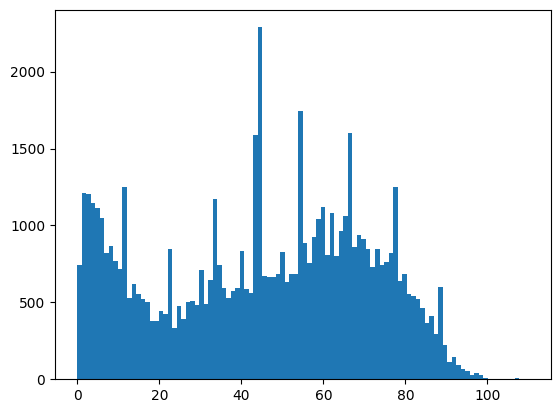

In [85]:
df['age'].hist(grid=False, bins=100)

In [86]:
df['age_cod'].unique()

array(['YR'], dtype=object)

In [87]:
#Remove rows where age is NA and age_cod is NA
#df = df.loc[~(df['age'].isna() & df['age_cod'].isin(['NA', 'Na', None, 'nan', 'NaN']))]

# Calculate the mean age for each drug and broadcast it to all rows
df['mean_age'] = df.groupby('ps_drugname')['age'].transform('mean')

# Replace NA ages with the mean age for the corresponding drug
df['age'] = df['age'].fillna(df['mean_age'])

# Drop the temporary column if no longer needed
df.drop(columns=['mean_age'], inplace=True)

#mean_age = float(round(df['age'].mean()))

# for index,row in df.iterrows():
#    if row["age_cod"] == 'na' or row["age_cod"] == 'nan' or pd.isna(row["age"]):
#         df.at[index,'age'] = mean_age
#         df.at[index,"age_cod"] = "YR"

# df.fillna(mean_age)

df['age'] = df['age'].astype(float)

print("Mean age in years overall:",df['age'].mean())

Mean age in years overall: 45.02596304966265


<Axes: ylabel='Frequency'>

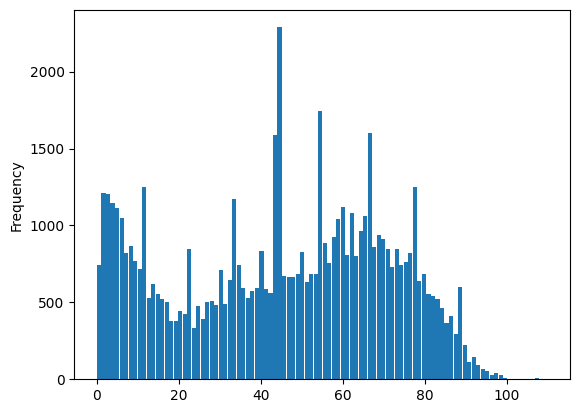

In [58]:
#Plotting the df['age']
df['age'].plot.hist(bins=100, rwidth=0.9)

In [59]:
# Change sex that are not 'M' or 'F' to 'UNK'
df['sex'] = df['sex'].astype(str)

for index,row in df.iterrows():
    if row["sex"] != "F" and row["sex"] != "M":
        df.at[index,"sex"] = "UNK"

In [60]:
columns = ['allergy_medication', 'age', 'sex', 'is_p']
categorical = ['allergy_medication', 'sex','is_p']
continuous = ['age']
df = df.reset_index()
mytable1 = TableOne(df, columns=columns, categorical=categorical, continuous=continuous, pval=False)
print(mytable1.tabulate(tablefmt = "fancy_grid"))

╒═══════════════════════════╤═══════════╤═══════════╤══════════════╕
│                           │           │ Missing   │ Overall      │
╞═══════════════════════════╪═══════════╪═══════════╪══════════════╡
│ n                         │           │           │ 63610        │
├───────────────────────────┼───────────┼───────────┼──────────────┤
│ allergy_medication, n (%) │ Accolate  │           │ 211 (0.3)    │
├───────────────────────────┼───────────┼───────────┼──────────────┤
│                           │ Allegra   │           │ 9760 (15.3)  │
├───────────────────────────┼───────────┼───────────┼──────────────┤
│                           │ Claritin  │           │ 13456 (21.2) │
├───────────────────────────┼───────────┼───────────┼──────────────┤
│                           │ Singulair │           │ 18033 (28.3) │
├───────────────────────────┼───────────┼───────────┼──────────────┤
│                           │ Xyzal     │           │ 2749 (4.3)   │
├───────────────────────────┼─────

In [62]:
#Years between drug approval and report date
df['caseid'] = df['caseid'].astype(int)

#Lowering the strings of the drugname column
df['ps_drugname'] = df['ps_drugname'].str.strip().str.lower()
df['ss_drugname'] = df['ss_drugname'].apply(lambda x: [i.strip().lower() for i in x])

#This is converting the date columns to datetime objects
df['init_fda_dt'] = pd.to_datetime(df['init_fda_dt'], format='%Y%m%d', errors='coerce')
df['event_dt'] = pd.to_datetime(df['event_dt'], format='%Y%m%d', errors='coerce')
df['rept_dt'] = pd.to_datetime(df['rept_dt'], format='%Y%m%d', errors='coerce')
df['fda_dt'] = pd.to_datetime(df['fda_dt'], format='%Y%m%d', errors='coerce')

#This is subsetting the data to only include the years 2004-2019; before Singulair got its boxed warning
#df = df[(df['fda_dt'].dt.year < 2020)]

print(df['ps_drugname'].unique())
print(df['fda_dt'].dt.year.unique())

['singulair' 'accolate' 'zyflo' ... '3-dehydroretinol' 'norethindrone'
 'wegovy']
[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023 2024 1998]


In [ ]:
#Dates of approval
#CHANGE THIS, USE TARGET DRUGS DATES IN CSV
drug_approval_dates = {
    'Singulair': pd.to_datetime('19980220', format='%Y%m%d'),
    'Zyrtec': pd.to_datetime('19960927', format='%Y%m%d'),
    'Claritin': pd.to_datetime('19930412', format='%Y%m%d'),
    'Allegra': pd.to_datetime('19960725', format='%Y%m%d'),
    'Accolate': pd.to_datetime('19960926', format='%Y%m%d'),
    'Zyflo': pd.to_datetime('19961209', format='%Y%m%d'),
    'Xyzal': pd.to_datetime('20070525', format='%Y%m%d')
}

for drug in drug_approval_dates:
    df.loc[df['allergy_medication'] == drug, 'approval_date'] = drug_approval_dates[drug]
df['approval_date'] = pd.to_datetime(df['approval_date'], format='%Y%m%d', errors='coerce')

In [65]:

#Find difference between event date and approval date
df['days_since_approval'] = (df['fda_dt'] - df['approval_date']).dt.days
df['years_since_approval'] = round((df['fda_dt'] - df['approval_date']).dt.days/365)


#Remove rows where days_since_approval is negative
df = df.loc[df['days_since_approval'] >= 0]
df = df.loc[df['years_since_approval'] >= 0]

In [66]:
#Add a column to the dataframe called got_warning, which is 1 if singulair is ps_drugname and 0 otherwise
df['got_warning'] = np.where(df['ps_drugname'] == 'singulair', 1, 0)

In [16]:
df.to_csv('cleaned_target_drugs.csv', index=False)

Additional columns to add:
- Days/Years between drug approval and report
- Dummy variable for indication
- Replace null ages with average age for that drug